In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def data_preprocess(data,ticker,forecast_days):

    data.drop([0,1],axis=0,inplace=True)
    
    data['Date'] = pd.to_datetime(data['Price'])
    data.set_index('Date',inplace=True)
    data.drop('Price',axis=1,inplace=True)
    
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric,errors='coerce')
    
    data.dropna(inplace=True)
    
    data.head()
    
    plt.figure(figsize=(10,4))
    plt.plot(data["Close"])
    plt.title(f'{ticker} Stock data')
    

def indicators(data,forecast_days):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

    data.dropna(inplace=True)
    
    global scale_close 
    scale_close = MinMaxScaler()
    scale_high = MinMaxScaler()
    scale_low = MinMaxScaler()
    scale_open = MinMaxScaler()
    scale_vol = MinMaxScaler()
    scale_sma10 = MinMaxScaler()
    scale_sma20 = MinMaxScaler()
    scale_sma50 = MinMaxScaler()
    scale_ema20 = MinMaxScaler()

    data["Close"] = scale_close.fit_transform(data[["Close"]])
    data["High"] = scale_high.fit_transform(data[["High"]])
    data["Low"] = scale_low.fit_transform(data[["Low"]])
    data["Open"] = scale_open.fit_transform(data[["Open"]])
    data["Volume"] = scale_vol.fit_transform(data[["Volume"]])
    data["SMA_10"] = scale_sma10.fit_transform(data[["SMA_10"]])
    data["SMA_20"] = scale_sma20.fit_transform(data[["SMA_20"]])
    data["EMA_20"] = scale_ema20.fit_transform(data[["EMA_20"]])
    data["SMA_50"] = scale_sma50.fit_transform(data[["SMA_50"]])
    
    time_step = 60
    X, y = create_dataset(data, time_step)
    train_model(data,X,y,forecast_days)


def create_dataset(data, time_step=60):
    # y only has close vals
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data.iloc[i:(i + time_step)].values)
        y.append(data.iloc[i + time_step]["Close"])
        
    global last_sequence 
    last_sequence = np.expand_dims(X[-1], axis=0)
    
    return np.array(X), np.array(y)

def train_model(data,X,y,forecast_days):
    train_size = int(len(data) * 0.8)
    train_X = X[:train_size]
    test_X = X[train_size:]

    train_y = y[:train_size]
    test_y = y[train_size:]
    
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_X, train_y, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
    
    predict(test_X,test_y,model,forecast_days)
    model.save('my_model.keras')


def predict(test_X,test_y,model,forecast_days):
    y_pred = model.predict(test_X)
    y_pred_scale = scale_close.inverse_transform(y_pred)
    test_y_actual = scale_close.inverse_transform(test_y.reshape(-1, 1))
    
    mse = mean_squared_error(test_y_actual, y_pred_scale)
    r2 = r2_score(test_y_actual, y_pred_scale)
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R2) Score: {r2}")

    plt.figure(figsize=(10, 5))
    plt.plot(test_y_actual, label='Actual Close',marker='o')
    plt.plot(y_pred_scale, label='Predicted Close',marker='x')
    plt.legend()
    plt.ylabel("Close Price")
    plt.title("Actual vs Predicted Close Price")
    plt.grid(True)
    plt.show()
    
    forecast(model,last_sequence,forecast_days)
    
def forecast(model, last_sequence, forecast_days):
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(forecast_days):
        pred = model.predict(current_sequence)
        predictions.append(pred[0][0])

     
        new_step = current_sequence[0, -1, :].copy()
        # Replace the 'Close' (assume it's the first column)
        new_step[0] = pred[0][0]  # Update Close (adjust index if Close isn't first)
 
        new_sequence = np.append(current_sequence[0, 1:, :], [new_step], axis=0)
        current_sequence = np.expand_dims(new_sequence, axis=0)

     
    pred_array = np.array(predictions).reshape(-1, 1)
    pred_actual = scale_close.inverse_transform(pred_array)
    
    print("Forecasted Close Prices:")
    for i, val in enumerate(pred_actual.flatten(), 1):
        print(f"Day {i}: {val:.2f}")

   
    plt.figure(figsize=(10, 4))
    plt.plot(pred_actual, marker='o', label='Forecasted Close')
    plt.title(f'{forecast_days}-Day Forecast')
    plt.xlabel('Day')
    plt.ylabel('Predicted Close Price')
    plt.grid(True)
    plt.legend()
    plt.show()



Epoch 1/10


c:\Users\sindh\OneDrive\Desktop\stock_market\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - loss: 0.0556 - val_loss: 0.0027
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0045 - val_loss: 0.0030
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0030 - val_loss: 0.0013
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Mean Squared Error (MSE): 188.52090741226368
R-squared (R2) Score: 0.6916174500562507


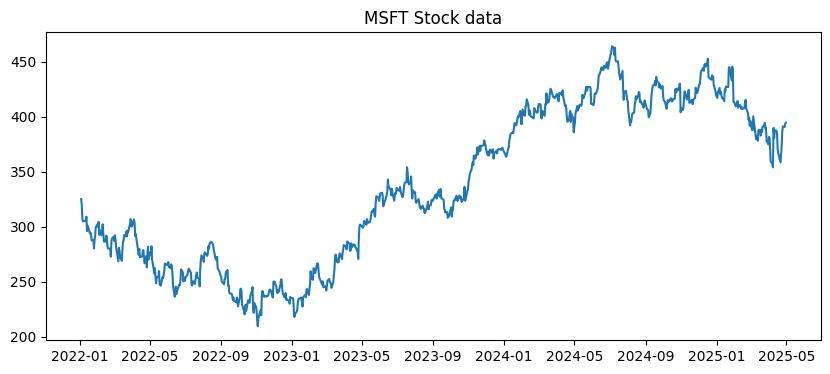

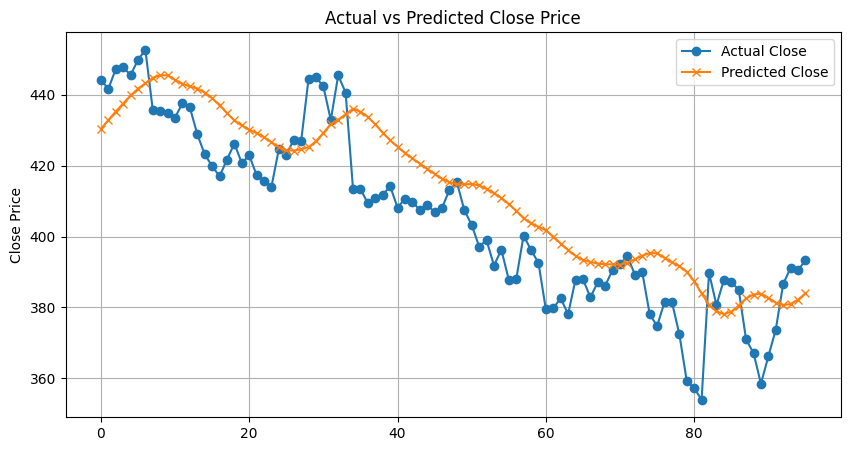

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Forecasted Close Prices:
Day 1: 383.95
Day 2: 385.78
Day 3: 387.55
Day 4: 389.16
Day 5: 390.57


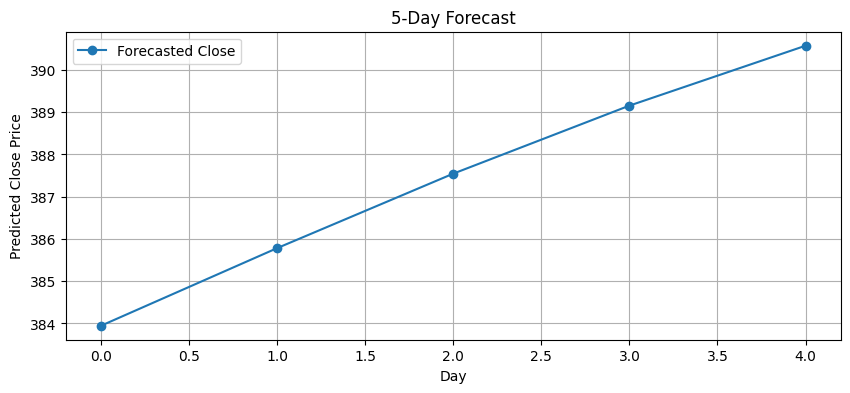

In [8]:
file_path = 'MSFT_data.csv'
df = pd.read_csv(file_path)

forecast_days = 5
ticker = "MSFT"

data_preprocess(df, ticker, forecast_days)
indicators(df, forecast_days)


In [ ]:
model.save('my_model')